#Markdown

```plaintext
RL/
├── env/
│   ├── grid.py
│   ├── gridln.py
│   ├── gridnn.py
│   ├── mountainln.py
│   ├── robot.py           ← Gazebo interface and Environment
│   └── robot_old.py
├── rl/
│   ├── dp.py              ← Dynamic programming
│   ├── rl.py              ← Core RL logic
│   ├── rlln.py            ← Linear approximation model
│   ├── rlnn.py            ← Non-linear model 
│   └── rlselect.py        ← "Runs" code for running experimental trials comparing
│
├── Assessment2.ipynb      ← This code part of submission
├── robot_environment.py   ← vRobEnv includes state representation and reward structure

```

# Imports / Constants

In [ ]:
%matplotlib inline
import torch
import numpy as np
from env.robot import *
import numpy as np
from math import pi
from time import sleep
#from tqdm import tqdm

from tqdm.notebook import tqdm
import sys
import termios
import tty
import select
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import numpy as np

from robot_environment import *
from rl.rlnn import *

#ACTIONS - make the code easier to read
FORWARDS = 1
LEFT = 0
RIGHT = 2

#Really want it deterministic
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#GPU support?
print(torch.cuda.is_available()) 
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0)) 

ModuleNotFoundError: No module named 'pandas'

In [3]:
#Need to nuke write protection for these files
#sudo chmod 777 /opt/ros/humble/share/turtlebot3_gazebo/worlds/turtlebot3_assessment2/burger.model
#sudo chmod 777 /opt/ros/humble/share/turtlebot3_gazebo/models/turtlebot3_burger/model.sdf

accelerate_sim(speed=100)
set_nscans_LiDAR(nscans=64)

### Common / Helper Functions

In [2]:
def print_robot_odom(env: RobEnv):
    #note: env.x and env.y are rounded to 1dp
    print (f"Odom. Pos:[{env.x},{env.y}] Yaw:{env.θ}")

# Connect to ROS / Configure Environment

1) Launch simulation environment
2) init ros (connect to ROS DDS eventing)
3) create environment

In [2]:

# Start Gazebo
# Assessment world:
# ros2 launch turtlebot3_gazebo turtlebot3_assessment2.launch.py

# Other worlds
# ros2 launch turtlebot3_gazebo turtlebot3_simple.launch.py 
# ros2 launch turtlebot3_gazebo empty_world.launch.py
# ros2 launch turtlebot3_gazebo turtlebot3_world.launch.py
# ros2 launch turtlebot3_gazebo turtlebot3_house.launch.py
# rviz2 

if not ros.ok():
    ros.init()

nscans = get_nscans_LiDAR()
print(f"Num laser scans in sensor:'{nscans}'")
# set_nscans_LiDAR(nscans=64)

# accelerate_sim(speed=10)
# Note running on my machine (AMD Ryzen 9 7950X, 64GB RAM, 3080TI) I got a stable Real Time Factor of 1.00 in the simulation.
# I had problems if I set the real time target to more than this, and from reading up this is a knowm limitation in the old Gazebo environment
# the new Gazebo Sim properly abstracts time so there is a simulation time independent from wall clock time. This version doesn't play nicely unless it's 1:1
# See Simulation Speed in ROS/Gazebo   




Num laser scans in sensor:'360'


In [ ]:
#Values (see calibration below for how these values were picked for the most repeatable settings)
θspeed = pi/3.5
speed = 10.0
n = 6

env = RobEnv(speed=speed, θspeed=θspeed, n=n, verbose=True)
env.reset()
print_robot_odom(env)


4

In [12]:
#Test connection

for _ in range(10): env.step()

print_robot_odom(env)

env.reset()

Odom. Pos:[1.2,-0.1] Yaw:6.18


3

In [ ]:
def forward_test(env, speed=2.0):
    env.speed = speed
    env.reset()
    
    steps = 10
    for _ in tqdm(range(steps), desc=f"Moving at speed {speed}", leave=False):
        env.step(FORWARDS)

    yDriftPerStep = env.y / steps
    xPerStep = env.x / steps
    #print(f"Speed {speed}: y drift = {yDriftPerStep:.4f}, x per step: {xPerStep:.4f}")

    BACKWARDS = -1 #not used in simulation, just used to test repeatability
    for _ in tqdm(range(steps), desc=f"Moving at speed {speed}", leave=False):
        env.step(BACKWARDS)

    xDrift = env.x

    return yDriftPerStep, xPerStep, xDrift

num_trials = 5
speeds = [0.5, 1.0, 2.0, 3.0,5.0, 10.0]
log = {"speed": [], "trial": [], "yDriftPerStep": [], "xPerStep": [], "xDrift": []}

for speed in tqdm(speeds, desc="Speeds"):
    for trial in tqdm(range(num_trials), desc=f"Trials at speed {speed}", leave=False):
        y_drift, x_step, xDrift = forward_test(env, speed=speed)
        log["speed"].append(speed)
        log["trial"].append(trial)
        log["yDriftPerStep"].append(y_drift)
        log["xPerStep"].append(x_step)
        log["xDrift"].append(xDrift)


plt.figure(figsize=(15, 5))

# Plot y drift per step
plt.subplot(1, 3, 1)
for speed in speeds:
    y_drift_vals = [log["yDriftPerStep"][i] for i in range(len(log["speed"])) if log["speed"][i] == speed]
    plt.plot(range(num_trials), y_drift_vals, marker='o', label=f"Speed {speed}")

plt.title('Y Drift per Step across Trials')
plt.xlabel('Trial')
plt.ylabel('Y Drift per Step')
plt.legend()
plt.grid(True)

# Plot x movement per step
plt.subplot(1, 3, 2)
for speed in speeds:
    x_step_vals = [log["xPerStep"][i] for i in range(len(log["speed"])) if log["speed"][i] == speed]
    plt.plot(range(num_trials), x_step_vals, marker='o', label=f"Speed {speed}")
plt.title('X Movement per Step across Trials')
plt.xlabel('Trial')
plt.ylabel('X per Step')
plt.legend()
plt.grid(True)

# Plot total x drift
plt.subplot(1, 3, 3)
for speed in speeds:
    x_drift_vals = [log["xDrift"][i] for i in range(len(log["speed"])) if log["speed"][i] == speed]
    plt.plot(range(num_trials), x_drift_vals, marker='o', label=f"Speed {speed}")
plt.title('Total X Drift across Trials')
plt.xlabel('Trial')
plt.ylabel('Total X Drift')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

display(log)

In [ ]:
def measure_rotation(robot : RobEnv, nTrials=20, frequency=10, angular_velocity=0.3, nSteps=8):
    
    robot.freq = frequency
    robot.angular_velocity = angular_velocity   
    robot.n = nSteps

    results  = np.zeros((nTrials, 2)) 
    start_time = time.time()

    for i in range(nTrials):
        robot.reset()

        step_count = 0
        full_rotation_detected = False
        half_rotation_detected = False

        pbar = tqdm(desc="Calibrating Rotation", unit="step")
        while(not full_rotation_detected):
            
            step_count += 1
            robot.step(LEFT)

            pbar.set_postfix({
                "rotation (°)": f"{np.degrees(robot.θ):.2f}",
                "step": step_count,
                "elapsed (s)": f"{time.time() - start_time:.1f}"
            })

            if (robot.θ > pi):
                half_rotation_detected = True
            if (robot.θ <pi and half_rotation_detected):
                full_rotation_detected = True
            
        #print(f"step_count:{step_count}: final position: {np.degrees(robot.θ):.2f} degrees")
        results [i,0] = robot.θ
        results [i,1] = step_count
    
    return results

#Let's try to find the best parameters for the rotation
frequencies = [10,20,30]
angular_velocities = [0.3, 0.6, 0.9]
nSteps = [8,16,32]

for frequency in frequencies:
    for angular_velocity in angular_velocities: 
        for n in nSteps:
            results = measure_rotation(env, nTrials=20, frequency=frequency, angular_velocity=angular_velocity, nSteps=n)
            angle_per_turn = (2 * np.pi + results[:, 0]) / results[:, 1]
            results = np.hstack([results, angle_per_turn[:, None]])

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

            # Plot final errors
            ax1.plot(np.degrees(results[:,2]), 'o-')
            ax1.set_title(f'Rotation per Step frequency:{frequency} angular_velocity:{angular_velocity} n:{n}')
            ax1.set_xlabel('Trial Number')
            ax1.set_ylabel('Rotation (degrees)')
            ax1.grid(True)

            # Plot step counts
            ax2.plot(results[:,1], 'o-')
            ax2.set_title('Steps Taken vs Trial')
            ax2.set_xlabel('Trial Number')
            ax2.set_ylabel('Number of Steps')
            ax2.grid(True)

            plt.tight_layout()
            plt.savefig(f'plot_measure_rotation_{frequency}_{angular_velocity}_{n}.png')
            plt.show()

# Model 1: Action-value with linear function approximation

RL method explanation + justification

State representation

Reward function

Hyperparameter tuning

Learning curves + discussion

In [13]:
#Assumptions
#

## State representation

Explain design


In [ ]:
%matplotlib inline
import torch
import numpy as np
from env.robot import *
import numpy as np
from math import pi
from time import sleep
#from tqdm import tqdm

from tqdm.notebook import tqdm
import sys
import termios
import tty
import select
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import numpy as np


from robot_environment import *
from rl.rlnn import *

#ACTIONS - make the code easier to read
FORWARDS = 1
LEFT = 0
RIGHT = 2

#Really want it deterministic
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#GPU support?
print(torch.cuda.is_available()) 
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0)) 


if not ros.ok():
    ros.init()  

max_t = 2000
ε = 0.2
εmin = 0.05
dε = (ε - εmin) / max_t

hyperparameters = {
    'max_t':max_t,
    'ε': ε, #Initial value Used in the epsilon Greedy so it will be random ε times per request for a next action
    'εmin': εmin, # epsilon decreases (there's a theory that if this decreases to 0 at infinity you're ll have teh optimum solution)
    'dε': dε, # dtop in epsilon per step
    'α': 0.05, # learning rate how much of the new informatin is used to update the existing value prediction         
    'γ': 0.99, # discount factor, large means that the rewards in the future contribute to the current action state prediction a lot         
    'λ': 0.6, # trace decay for the eligibility trace 1 is MC, 0 is just the last step

    'verbose': False,
    
    # Robot Environment params
    'θspeed': pi / 2, 
    'speed': 3.0,        
    'n': 3    
}

env = vRobEnv(
    speed=hyperparameters['speed'],
    θspeed=hyperparameters['θspeed'],
    n=hyperparameters['n'],
    verbose=hyperparameters['verbose']
)

vqlearn = Sarsaλ(
    env=env,
    α=hyperparameters['α'],          
    γ=hyperparameters['γ'],          
    λ=hyperparameters['λ'],           
    ε=hyperparameters['ε'],            
    εmin=hyperparameters['εmin'],        
    dε=hyperparameters['dε'],        
    q0=0,             
    Tstar=0,          
    max_t=1200,       
    episodes=200,     
    self_path='SarsaLambda.three_levels.test009.pkl',
    seed=1,
    **demoGame()
)

print(hyperparameters)
vqlearn.interact(resume=False, save_ep=True)

True
NVIDIA GeForce RTX 3080 Ti
speed  =  2.0
θspeed =  0.52
state size(laser beams)= 64


{'max_t': 2000,
 'ε': 0.2,
 'εmin': 0.05,
 'dε': 7.500000000000001e-05,
 'α': 0.05,
 'γ': 0.99,
 'λ': 0.6,
 'verbose': False,
 'θspeed': 0.5235987755982988,
 'speed': 2.0,
 'n': 3}

In [ ]:


%matplotlib inline
import torch
import numpy as np
from env.robot import *
import numpy as np
from math import pi
from time import sleep
#from tqdm import tqdm

from tqdm.notebook import tqdm
import sys
import termios
import tty
import select
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import numpy as np


from robot_environment import *
from rl.rlnn import *

#ACTIONS - make the code easier to read
FORWARDS = 1
LEFT = 0
RIGHT = 2

#Really want it deterministic
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#GPU support?
print(torch.cuda.is_available()) 
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0)) 


if not ros.ok():
    ros.init()  

max_t = 2000
ε = 0.2
εmin = 0.05
dε = (ε - εmin) / max_t

hyperparameters = {
    'max_t':max_t,
    'ε': ε, #Initial value Used in the epsilon Greedy so it will be random ε times per request for a next action
    'εmin': εmin, # epsilon decreases (there's a theory that if this decreases to 0 at infinity you're ll have teh optimum solution)
    'dε': dε, # dtop in epsilon per step
    'α': 0.05, # learning rate how much of the new informatin is used to update the existing value prediction         
    'γ': 0.99, # discount factor, large means that the rewards in the future contribute to the current action state prediction a lot         
    'λ': 0.6, # trace decay for the eligibility trace 1 is MC, 0 is just the last step

    'verbose': False,
    
    # Robot Environment params
    'θspeed': pi / 2, 
    'speed': 3.0,        
    'n': 3    
}

env = vRobEnvCornerDetector(
    speed=hyperparameters['speed'],
    θspeed=hyperparameters['θspeed'],
    n=hyperparameters['n'],
    verbose=hyperparameters['verbose']
)

vqlearn = Sarsaλ(
    env=env,
    α=hyperparameters['α'],          
    γ=hyperparameters['γ'],          
    λ=hyperparameters['λ'],           
    ε=hyperparameters['ε'],            
    εmin=hyperparameters['εmin'],        
    dε=hyperparameters['dε'],        
    q0=0,             
    Tstar=0,          
    max_t=1200,       
    episodes=200,     
    self_path='SarsaLambda.three_levels.test009.pkl',
    seed=1,
    **demoGame()
)

print(hyperparameters)
vqlearn.interact(resume=False, save_ep=True)

In [ ]:

%matplotlib inline
import torch
import numpy as np
from env.robot import *
import numpy as np
from math import pi
from time import sleep
#from tqdm import tqdm

from tqdm.notebook import tqdm
import sys
import termios
import tty
import select
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import numpy as np


from robot_environment import *
from rl.rlnn import *

#ACTIONS - make the code easier to read
FORWARDS = 1
LEFT = 0
RIGHT = 2

#Really want it deterministic
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#GPU support?
print(torch.cuda.is_available()) 
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0)) 


if not ros.ok():
    ros.init()  


for ε in [0.1,0.2,0.5]:
    for λ in [0.1,0.3,0.5,0.8,1.1]:
        for γ in [0.1,0.5,0.99]:

            max_t = 10
            εmin = 0.05
            dε = (ε - εmin) / max_t
        
            hyperparameters = {
                'max_t':max_t,
                'ε': ε, #Initial value Used in the epsilon Greedy so it will be random ε times per request for a next action
                'εmin': εmin, # epsilon decreases (there's a theory that if this decreases to 0 at infinity you're ll have teh optimum solution)
                'dε': dε, # dtop in epsilon per step
                'α': 0.05, # learning rate how much of the new informatin is used to update the existing value prediction         
                'γ': 0.99, # discount factor, large means that the rewards in the future contribute to the current action state prediction a lot         
                'λ': 0.6, # trace decay for the eligibility trace 1 is MC, 0 is just the last step
            
                'verbose': False,
                
                # Robot Environment params
                'θspeed': pi / 2, 
                'speed': 3.0,        
                'n': 3    
            }
            print(hyperparameters)
            
            env = vRobEnvCornerDetector(
                speed=hyperparameters['speed'],
                θspeed=hyperparameters['θspeed'],
                n=hyperparameters['n'],
                verbose=hyperparameters['verbose']
            )
            
            vqlearn = Sarsaλ(
                env=env,
                α=hyperparameters['α'],          
                γ=hyperparameters['γ'],          
                λ=hyperparameters['λ'],           
                ε=hyperparameters['ε'],            
                εmin=hyperparameters['εmin'],        
                dε=hyperparameters['dε'],        
                q0=0,             
                Tstar=0,          
                max_t=hyperparameters['max_t'],       
                episodes=5,     
                self_path='SarsaLambda.vRobEnvCornerDetector.test012.pkl',
                seed=1,
                plotT=True, 
                plotR=True,
                visual=True, 
                animate=False
            )
            
            vqlearn.interact(resume=False, save_ep=True, plot_exp = True)

In [ ]:
stop here

#set_nscans_LiDAR(nscans=64)
#sdfdsfs

SyntaxError: invalid syntax (3964023741.py, line 1)

In [ ]:
resume = False

if resume:
    vqlearn = Qlearn.selfload(self_path='vQlearn_exp')
    vqlearn.env = venv
    vqlearn.episodes = 105 # extend sthe number of episodes

# saving the object after each episode for retrieval in case of a crash 
%time vqlearn.interact(resume=resume, save_ep=True) 

reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.3333333333333333 = SUM (-1,0,0,0.2)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.3333333333333333 = SUM (-1,0,0,0.2)
reward:-0.3333333333333333 = SUM (-1,0,0,0.2)
reward:-0.3333333333333333 = SUM (-1,0,0,0.2)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.3333333333333333 = SUM (-1,0,0,0.2)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.3333333333333333 = SUM (-1,0,0,0.2)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (-1,0,0,0.0)
reward:-0.6666666666666666 = SUM (

KeyboardInterrupt: 

# Model 2: Either policy gradient or value-based with non-linear function approximation

I have also provided you with the ability to easily create a simple, fully connected neural network in the nnMRP class. You do not need to do a lot; the size of the input dictates the choice between a CNN-based model and a fully connected neural network. You may use either in your project, but using a traditional network, not a CNN, is easier and less time-consuming. The CNN-based one is for learning from the pixels of an input image; we are just using the laser reading in our project.

I’ve also made slight changes to rl.rl.py to enable storing and retrieving an object (via pickle), which can be useful in case of unexpected crashes—something not uncommon in robotics.

Please ensure you download turtlebot3.zip as well to guarantee the environment runs smoothly without any missing files. If you run into any issues, feel free to reach out.

CPU times: user 41min 34s, sys: 5min 16s, total: 46min 50s
Wall time: 1h 2min


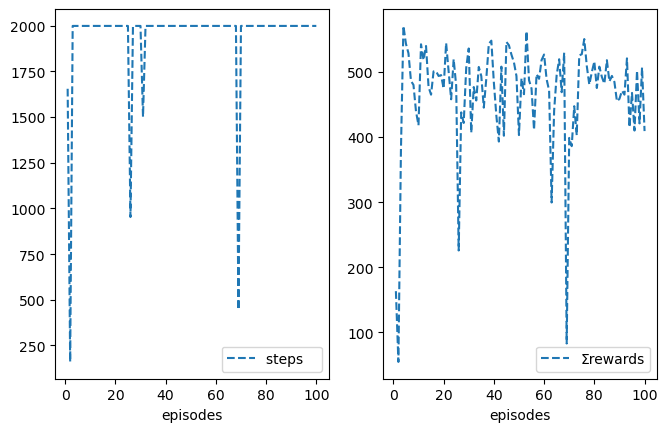

In [1]:
%matplotlib inline
import torch
import numpy as np
from env.robot import *
import numpy as np
from math import pi
from time import sleep
#from tqdm import tqdm

from tqdm.notebook import tqdm
import sys
import termios
import tty
import select
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
import numpy as np


from robot_environment import *
from rl.rlnn import *

#ACTIONS - make the code easier to read
FORWARDS = 1
LEFT = 0
RIGHT = 2

#Really want it deterministic
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#GPU support?
print(torch.cuda.is_available()) 
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0)) 

if not ros.ok():
    ros.init()


class nnRobEnv(vRobEnv):
    def __init__(self, **kw):
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
        super().__init__(**kw)
        self.nF = len(self.scans)
        
    def s_(self):
        max, min = self.max_range, self.min_range
        normalised =  ((self.scans - min)/(max - min))
        return torch.tensor(normalised, dtype=torch.float32).to(self.device)

env = nnRobEnv()

class cudaDQN(nnMDP):
    def __init__(self, α=1e-4, t_Qn=1000, **kw):
        print('--------------------- 易  cudaDQN is being set up 易 -----------------------')
        self.device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
        super().__init__(**kw)
        self.α = α
        self.store = True
        self.t_Qn = t_Qn
        
    def greedy(self, s):
        self.isamax = True
        Qs = self.Q_(s)
        Qs_np = Qs.detach().cpu().numpy() #WE NEED TO BRING THE DATA BACK FROM THE GPU for NUMPy
        from numpy.random import choice
        return choice((Qs_np == Qs_np.max()).nonzero()[0])

    def online(self, *args):
        if len(self.buffer) < self.nbatch:
            return

        (s, a, rn, sn, dones), inds = self.batch()

        Qs = self.qN(s)
        Qn = self.qNn(sn).detach()
        Qn[dones] = 0

        target = Qs.clone().detach()
        target[inds, a] = self.γ * Qn.max(1).values + rn.to(self.device)
        loss = self.qN.fit(Qs, target)

        if self.t_ % self.t_Qn == 0:
            self.qNn.set_weights('Q', self.t_)
            print(f'loss = {loss}')


nnqlearn = cudaDQN(
    env=env, 
    episodes=100, 
    α=1e-4,
    ε=0.5, 
    dε=.99, 
    εmin=0.01, 
    γ=.95, 
    h1=3, 
    h2=3, 
    nF=env.nF,
    nbuffer=5000, 
    nbatch=32, 
    endbatch=8,
    t_Qn=100, 
    self_path='DQN_exp.pkl',
    seed=1, 
    **demoGame())

for layer in nnqlearn.qN.layers:
    print(layer.weight)
    # print(layer.bias)


%time nnqlearn.interact(resume=False, save_ep=True) 

# Framework bugs

## Race for state not seen
```plaintext
'''
---------------------------------------------------------------------------
IndexError                                Traceback (most recent call last)
File <timed eval>:1

File ~/git/turtlebot-as2/rl/rl.py:192, in MRP.interact(self, train, resume, save_ep, episodes, grid_img, **kw)
    189 self.t += 1
    190 self.t_+= 1
--> 192 rn,sn, a,an, done = self.step(s,a, self.t)  # takes a step in env and store tarjectory if needed
    193 self.online(s, rn,sn, done, a,an) if train else None # to learn online, pass a one step trajectory
    195 self.Σr += rn

File ~/git/turtlebot-as2/rl/rl.py:153, in MRP.step_an(self, s, a, t)
    151 if self.skipstep: return 0, None, None, None, True
    152 sn, rn, done, _ = self.env.step(a)
--> 153 an = self.policy(sn)
    155 # we added s=s for compatibility with deep learning later
    156 self.store_(s=s, a=a, rn=rn, sn=sn, an=an, done=done, t=t)

File ~/git/turtlebot-as2/rl/rl.py:487, in MDP.<locals>.MDP.εgreedy(self, s)
    484 if self.dε < 1: self.ε = max(self.εmin, self.ε*self.dε)              # exponential decay
    485 if self.εT > 0: self.ε = max(self.εmin, self.ε0 - self.t_ / self.εT) # linear      decay
--> 487 return self.greedy(s) if rand() > self.ε else randint(0, self.env.nA)

File ~/git/turtlebot-as2/rl/rl.py:477, in MDP.<locals>.MDP.greedy(self, s)
    474 # print(s)
    475 # print(Qs)
    476 if Qs.shape[0]==1: raise ValueError('something might be wrong number of actions ==1')
--> 477 return choices(np.where(Qs==Qs.max())[0])[0]

File /usr/lib/python3.10/random.py:519, in Random.choices(self, population, weights, cum_weights, k)
    517     floor = _floor
    518     n += 0.0    # convert to float for a small speed improvement
--> 519     return [population[floor(random() * n)] for i in _repeat(None, k)]
    520 try:
    521     cum_weights = list(_accumulate(weights))

File /usr/lib/python3.10/random.py:519, in <listcomp>(.0)
    517     floor = _floor
    518     n += 0.0    # convert to float for a small speed improvement
--> 519     return [population[floor(random() * n)] for i in _repeat(None, k)]
    520 try:
    521     cum_weights = list(_accumulate(weights))

IndexError: index 0 is out of bounds for axis 0 with size 0

FIXED BY EDITING rl.py

#------------------------------------- add some more policies types 易-------------------------------
        # useful for inheritance, gives us a vector of actions values
        def Q_(self, s=None, a=None):

            #Originally return self.Q[s] if s is not None else self.Q

            if s is None:
                return self.Q  
            
            #just initialise to 0 for now, not sure how to handle this.
            if s not in self.Q:
                self.Q[s] = np.zeros(self.env.nA) 
            
            return self.Q[s]

'''
```

## S_ instead of s_ in rl.py
```plaintext
--------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
File <timed eval>:1

File ~/git/turtlebot-as2/rl/rl.py:182, in MRP.interact(self, train, resume, save_ep, episodes, grid_img, **kw)
    179 done = False
    180 #print(self.ep)
    181 # initial step
--> 182 s,a = self.step_0()
    183 self.step0()                                    # user defined init of each episode
    184 # an episode is a set of steps, interact and learn from experience, online or offline.

File ~/git/turtlebot-as2/rl/rl.py:134, in MRP.step_0(self)
    132 def step_0(self):
    133     s = self.env.reset()                                 # set env/agent to the start position
--> 134     a = self.policy(s)
    135     return s,a

File ~/git/turtlebot-as2/rl/rl.py:499, in MDP.<locals>.MDP.εgreedy(self, s)
    496 if self.dε < 1: self.ε = max(self.εmin, self.ε*self.dε)              # exponential decay
    497 if self.εT > 0: self.ε = max(self.εmin, self.ε0 - self.t_ / self.εT) # linear      decay
--> 499 return self.greedy(s) if rand() > self.ε else randint(0, self.env.nA)

File ~/git/turtlebot-as2/rl/rl.py:485, in MDP.<locals>.MDP.greedy(self, s)
    483 self.isamax = True
    484 # instead of returning np.argmax(Q[s]) get all max actions and return one of the max actions randomly
--> 485 Qs = self.Q_(s)
    486 # print(s)
    487 # print(Qs)
    488 if Qs.shape[0]==1: raise ValueError('something might be wrong number of actions ==1')

File ~/git/turtlebot-as2/rl/rlln.py:149, in vMDP.Q_(self, s, a)
    145 def Q_(self, s=None, a=None):
    146     #print(f"{s.shape}, {a}")
    148     W = self.W if a is None else self.W[a]
--> 149     return W.dot(s) if s is not None else np.matmul(W, self.env.S_()).T

AttributeError: 'vRobEnv' object has no attribute 'S_'
```

# References

- Núñez, P., Vazquez-Martin, R., Bandera, A., and Romero-Gonzalez, C. (2015) ‘Feature extraction from laser scan data based on curvature estimation for mobile robotics’, *Robotics and Autonomous Systems*, 70, pp. 103–114. Available at: [https://robolab.unex.es/wp-content/papercite-data/pdf/feature-extraction-from-laser.pdf](https://robolab.unex.es/wp-content/publicaciones/2006/Nunez%20Trujillo,%20Vazquez-Martin,%20del%20Toro,%20Bandera%20%7C%20Feature%20extraction%20from%20laser%20scan%20data%20based%20on%20curvature%20estimation%20for%20mobile%20robotics.pdf) (Accessed: 26 April 2025).

- Ramos, J., Rocha, R., and Dias, J. (2022) ‘Efficient approach for extracting high-level B-spline features from laser scan data’, *Sensors*, 22(24), 9737. Available at: [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9737135/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9737135/) (Accessed: 26 April 2025).

- Shen, S., Michael, N., and Kumar, V. (2012) ‘Method for corner feature extraction from laser scan data’, *ResearchGate*. Available at: [https://www.researchgate.net/publication/288577925_Method_for_corner_feature_extraction_from_laser_scan_data](https://www.researchgate.net/publication/288577925_Method_for_corner_feature_extraction_from_laser_scan_data) (Accessed: 26 April 2025).

- Stack Overflow (2019) ‘How can I detect the corner from 2D point cloud or LiDAR scanned data?’, *Stack Overflow*. Available at: [https://stackoverflow.com/questions/59049990/how-can-i-detect-the-corner-from-2d-point-cloud-or-lidar-scanned-data](https://stackoverflow.com/questions/59049990/how-can-i-detect-the-corner-from-2d-point-cloud-or-lidar-scanned-data) (Accessed: 26 April 2025).


- CETI. (n.d.) *Simulation Speed in ROS/Gazebo*. Available at: [https://ceti.pages.st.inf.tu-dresden.de/robotics/howtos/SimulationSpeed.html](https://ceti.pages.st.inf.tu-dresden.de/robotics/howtos/SimulationSpeed.html) (Accessed: 26 April 2025).

- Furrer, F., Wermelinger, M., Naegeli, T., et al. (2021) ‘Dynamics and Control of Quadrotor UAVs: A Survey’, *IEEE Transactions on Robotics*, 37(5), pp. 1381–1400. Available at: [https://ieeexplore.ieee.org/document/9453594](https://ieeexplore.ieee.org/document/9453594) (Accessed: 26 April 2025).

- Perez-Perez, J., Jimenez, F. and Mata, M. (2023) ‘An Overview of Reinforcement Learning in Autonomous Driving: Fundamentals, Challenges, and Applications’, *Applied Sciences*, 13(12), p. 7202. Available at: [https://www.mdpi.com/2076-3417/13/12/7202](https://www.mdpi.com/2076-3417/13/12/7202) (Accessed: 26 April 2025).


# Appendicies

## Cool links / interesting reading: 
- https://github.com/hello-robot/stretch_ros/blob/master/stretch_funmap/README.md
- https://arxiv.org/pdf/2502.20607

## Miscelaneous Notes

### Setting up ROS
- https://emanual.robotis.com/docs/en/platform/turtlebot3/sbc_setup/
- https://ros2-industrial-workshop.readthedocs.io/en/latest/_source/navigation/ROS2-Turtlebot.html
- https://emanual.robotis.com/docs/en/platform/turtlebot3/navigation/
- https://emanual.robotis.com/docs/en/platform/turtlebot3/bringup/#bringup

### Multicast traffic (for DDS) through Windows FW to WSL2:
- https://eprosima-dds-router.readthedocs.io/en/latest/rst/examples/repeater_example.html#execute-example
- New-NetFirewallRule -Name 'WSL' -DisplayName 'WSL' -InterfaceAlias 'vEthernet (WSL (Hyper-V firewall))' -Direction Inbound -Action Allow
- New-NetIPAddress -InterfaceAlias 'vEthernet (WSL (Hyper-V firewall))' -IPAddress '192.168.1.217' -PrefixLength 24
- https://github.com/DanielBryars/multicast-test.git

### VM
- https://labs.azure.com/virtualmachines?feature_vnext=true